## Import Necessary Functions

In [1]:
import numpy as np
import pandas as pd
import pickle 
import sklearn 
import matplotlib.pyplot as plt 

## Import Train/Test Splits and Scaler

In [2]:
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('../data/test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
with open('../data/scaler_mv.pickle', 'rb') as f:
    scaler = pickle.load(f)

In [5]:
train_data.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [6]:
test_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-07-02 12:00:00,0.056338,0.897059,0.704918,0.218182,0.333333,0.005349,0.0,0.0
2014-07-02 13:00:00,0.064386,0.897059,0.721311,0.218182,1.000000,0.000752,0.0,0.0
2014-07-02 14:00:00,0.066398,0.897059,0.721311,0.200000,1.000000,0.002273,0.0,0.0
2014-07-02 15:00:00,0.072435,0.897059,0.737705,0.200000,1.000000,0.003794,0.0,0.0
2014-07-02 16:00:00,0.078471,0.897059,0.737705,0.200000,1.000000,0.005315,0.0,0.0


Everything looks right!

## Moving Window NOT CV

The LSTM takes sequences of inputs in training. This is somewhat a "moving window" approach where the model learns a sequence of 10 data points from each of the features and predicts the 11th pollution datapoint. The following function prepares the time series data for LSTM training.

X_sequences is an array of feature vectors for each time step in a 10-step sequence. The target variable (pollution) is the value at the subsequent point.

In [7]:
def generate_sequence(df,N, window_size):
        
    X_sequences = [df.iloc[i:i+window_size].values for i in range(N - window_size)]
    Y_values = [df.iloc[i+window_size]['pollution'] for i in range(N - window_size)]

    return np.array(X_sequences).astype('float64'), np.array(Y_values).astype('float64').reshape(-1,1)



Sequence size is related to the vanishing gradient problem. There is a limit for how well an LSTM can learn dependencies far back in long sequences. This is because the gradients in backpropogation get very small, making it difficult for the model to learn long term relationships. Hence 10 is good enough to capture relatively short-term patterns in the data.

In [8]:
window_size = 10
N= len(train_data)
X_train, y_train = generate_sequence(train_data,N, window_size)
print(X_train.shape, y_train.shape)

M=len(test_data)
X_test, y_test = generate_sequence(test_data,M,window_size)
print(X_test.shape,y_test.shape)




(39410, 10, 8) (39410, 1)
(4370, 10, 8) (4370, 1)


Note: we reshape input to be 3D [samples, timesteps, features]

This lets us tell the LSTM which data points belong to the same sequence and what features each time step contains.

In [9]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from math import sqrt




/Users/matt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
np.random.seed(7)

# Multivariate LSTM

A multivariate LSTM is used to predict pollution based on multiple input features that also vollow time series. In contrast, the univariate LSTM only pollution   to predict pollution. It is simpler and focuses solely on the temporal patterns of pollution.

We compare the two because MV LSTMs can learn how different variables influence each other over time, leading to potentially better predicitons if the features are indeed relevant. This addresses real world scenario where multiple variables might affect pollution e.g. Temperature. We want to know if the LSTM can pcik up on these real world dependencies or if the features simply add noise. If the univariate falls short in comparison on the left out data, then we can conclude there deeper dependencies lie in pollution prediction. And if not, we can conclude MV LSTM adds complexity and the increased computation reuqired is not necessary.

Please assume any mention of LSTM in the proceeding document, unless stated otherwise, is reffering to the multivariate LSTM

## Stacked LSTM

After testing various architectures, we came to the conclusion that the following stacked LSTM model balanced rsme and computational efficiency best. In the trial and error process, several different configurations were tried out with different LSTM layers, parameters, activation functions (like tanh and ReLU), and even applying batch normalization. This is the setup which generalised best and had the lowest computational performance.

A dropout layer of 10% is added after the first layer to avoid overfitting. Dropout helps to prevent overfitting by dropping a random portion of neurons during training which reduces sensitivity to the specific weights of individual neurons. For the Dense output layer, we have decided on a linear activation to output the final prediction. Tanh did well and shrunk extreme values better, and if we minmax scaled data to (-1,1) instead of (0,1), it would be preferred, but because the focus is on computational performance, linear was chosen.

The model is optimised using Adam, known for its adaptiveness while training. The learning rate of 0.001 was chosen after some trial and error.

A random seed is set because the dropout layer is randomly chosen by keras and we want to reproduce values.

In [12]:
tf.random.set_seed(7)
STCK_LSTM = Sequential()
STCK_LSTM.add(Input(shape =(n_steps, n_features)))
STCK_LSTM.add(LSTM(32,return_sequences=True))
STCK_LSTM.add(Dropout(0.1)) #Prevent overfitting
STCK_LSTM.add(LSTM(16, return_sequences=False))
STCK_LSTM.add(Dense(n_outputs, activation ='linear')) 

STCK_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])

# Save the initial weights of the model right after it is defined and compiled
initial_weights = STCK_LSTM.get_weights()

STCK_LSTM.summary()



2024-11-27 00:12:49.328816: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-27 00:12:49.328953: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-27 00:12:49.328998: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-27 00:12:49.329484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-27 00:12:49.329621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Early stopping is used here, which will give us an approximation of how many epochs we might want to use. By monitoring the validation loss, the model stops training when performance on validation data stops improving, which in turn preventing overfitting.  The approach not only decreases computation time due to unnecessary epochs but also helps fine-tune future runs by giving insight into how many epochs are typically enough without overfitting.

Note:
- We have to specify to use CPU because there were issues setting up a virtual environment and so the keras metal was being preferred by model. 
- We use the last 10% of data for validation, which is the same procedure for our left out set

In [14]:
with tf.device('/CPU:0'):
    history = STCK_LSTM.fit(X_train, y_train, epochs=150, validation_split=0.1,  callbacks=[early_stopping], batch_size=64,shuffle=False)

Epoch 1/150


2024-11-27 00:12:50.483253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 2/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 3/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 4/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 5/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 6/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 8.3589e-04 - val_root_mean_squared_error: 0.0289
Epoch 7/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step -

After 33 passes (epoch) the model has learnt enough and further iterations  of the dataset would only add to overfitting 

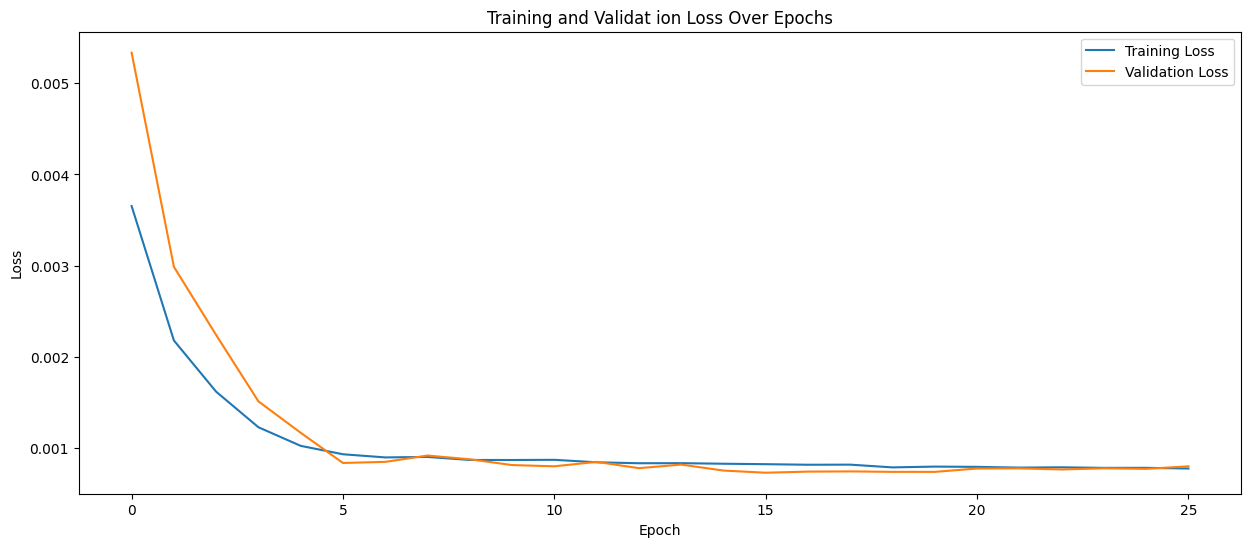

In [15]:
#Plot training and validation mse loss over epochs
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')      
plt.plot(history.history['val_loss'], label='Validation Loss')  

plt.xlabel('Epoch')   
plt.ylabel('Loss')      
plt.legend()
plt.title('Training and Validat ion Loss Over Epochs')
plt.show()

- The gradual decay in mle loss tells us we chose a good learning rate for Adam optimiser. 
- The validation loss is just a bit higher than the training loss at the start, which means the model is not overfitting.
- The training mse loss decreases steadily which means the model is correctly learning patterns in the training data. 
- The validation mse performs similar, decreasing until about epoch 10, where the early stopping kicked in soon after. Convergence of the two suggests that the model fits well because the validation mse loss does not diverge much from the training loss. 
- Stability after 10 suggests continuing training would overfit the training data.

In [16]:
split= int(0.9*len(X_train))

## Model epoch and rmse performance 

The model is trained incrementally, but it retains the weights from previous iterations. This means that the total effective training time for the model is the cumulative epoch count (eon).

**WARNING** this takes approx 8 minutes to run.

In [17]:
#Reset weights to initial weights before starting new training 
STCK_LSTM.set_weights(initial_weights)

epochs=[]
train_rmse=[]
val_rmse=[]
delta_epochs=5
eon=0
for i in range(0,10) : 
        print("epoch : " + str(eon))
        STCK_LSTM.fit(X_train, y_train, epochs=delta_epochs, batch_size=64,validation_split=0.1)
        train_scores = STCK_LSTM.evaluate(X_train[:split], y_train[:split])   
        val_scores = STCK_LSTM.evaluate(X_train[split:], y_train[split:])
        eon+=delta_epochs
        epochs.append(eon)
        train_rmse.append(train_scores[1]) #rmse
        val_rmse.append(val_scores[1])

epoch : 0
Epoch 1/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0033 - root_mean_squared_error: 0.0562 - val_loss: 9.6053e-04 - val_root_mean_squared_error: 0.0310
Epoch 2/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 6.8854e-04 - val_root_mean_squared_error: 0.0262
Epoch 3/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 9.2836e-04 - root_mean_squared_error: 0.0304 - val_loss: 6.3296e-04 - val_root_mean_squared_error: 0.0252
Epoch 4/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 8.9786e-04 - root_mean_squared_error: 0.0299 - val_loss: 6.2658e-04 - val_root_mean_squared_error: 0.0250
Epoch 5/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 8.4701e-04 - root_mean_squared_error: 0.0291 - val_loss: 6.2583e-04 - val_root_mean_squared_error: 0.0250
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.2569e-04 - root_mean_squared_error: 0.0301
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8237e-04 - root_mean_

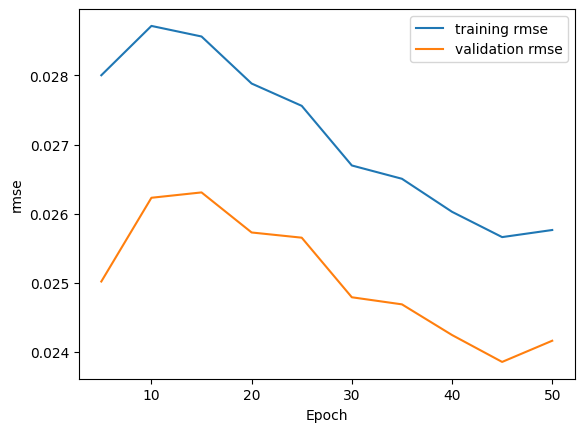

In [18]:
results=[epochs,train_rmse,val_rmse]
plt.plot(epochs,train_rmse,label='training rmse')
plt.plot(epochs,val_rmse,label='validation rmse')
plt.xlabel('Epoch') 
plt.ylabel('rmse') 
plt.legend()
plt.show()

In comparing the train and validation rmse over epochs, we observe both decrease steadily after 15 epochs suggesting the model is able to learn and fit better as training continues. We have to find a balance between learning the patterns well enough and not overfitting, it seems the training section rmse declines more rapidly after 25 epochs while the validation data is a more stable decline which tells us the model learns enough earlier on and shouldn't continue training if we want to avoid overfitting. 

Interestingly, the consistently lower validation rmse suggests that the model's predictions on the validation set are slightly more stable than its performance on the training set. This could be because the model struggles with handling relatively larger amounts of data, potentially. To test this hypothesis, we will experiment with randomly dropping out sections of time in our series. Since time series data are not exchangeable, meaning future patterns do not necessarily resemble the past, removing portions of the sequence should not significantly effect performance, but should tell us if less data generally means better performance for LSTM.

In [19]:

chunk = 168  #Length of each time chunk to remove
n_sections =  50      #Number of chunks to remove

n_sequences = len(X_train)

#Randomly select data points the chunk of time is from 
start_chunk = np.random.choice(range(n_sequences - chunk), size=n_sections, replace=False)

removed_data = []
for i in start_chunk:
    removed_data.extend(range(i, i + chunk))

removed_data = np.array(removed_data)  #We need sequences as array

X_train_copy = X_train.copy() #We don't want to change X_train directly
y_train_copy = y_train.copy()

#Create new training set by excluding the randomly chosen time chunks
X_train_reduced = np.delete(X_train_copy, removed_data, axis=0)
y_train_reduced = np.delete(y_train_copy, removed_data, axis=0)

X_train_reduced.shape, y_train_reduced.shape


((31847, 10, 8), (31847, 1))

In [20]:
split= int(0.9*len(X_train_reduced))

**WARNING** this takes approx 7 minutes to run.

In [21]:
# Reset weights to initial weights before starting new training 
STCK_LSTM.set_weights(initial_weights)

epochs=[]
train_rmse=[]
val_rmse=[]
delta_epochs=5
eon=0 
for i in range(0,10) : 
        print("epoch : " + str(eon))
        STCK_LSTM.fit(X_train_reduced, y_train_reduced, epochs=delta_epochs, batch_size=64,validation_split=0.1)
        train_scores = STCK_LSTM.evaluate(X_train_reduced[:split], y_train_reduced[:split])   
        val_scores = STCK_LSTM.evaluate(X_train_reduced[split:], y_train_reduced[split:])
        eon+=delta_epochs
        epochs.append(eon)
        train_rmse.append(train_scores[1]) #rmse
        val_rmse.append(val_scores[1])

epoch : 0
Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0034 - root_mean_squared_error: 0.0566 - val_loss: 9.9381e-04 - val_root_mean_squared_error: 0.0315
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 6.7044e-04 - val_root_mean_squared_error: 0.0259
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.1391e-04 - root_mean_squared_error: 0.0302 - val_loss: 6.8749e-04 - val_root_mean_squared_error: 0.0262
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.6483e-04 - root_mean_squared_error: 0.0294 - val_loss: 6.1733e-04 - val_root_mean_squared_error: 0.0248
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.2076e-04 - root_mean_squared_error: 0.0286 - val_loss: 6.1813e-04 - val_root_mean_squared_error: 0.0249
896/896 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.4400e-04 - root_mean_squared_error: 0.0271
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2997e-04 - root_mean_sq

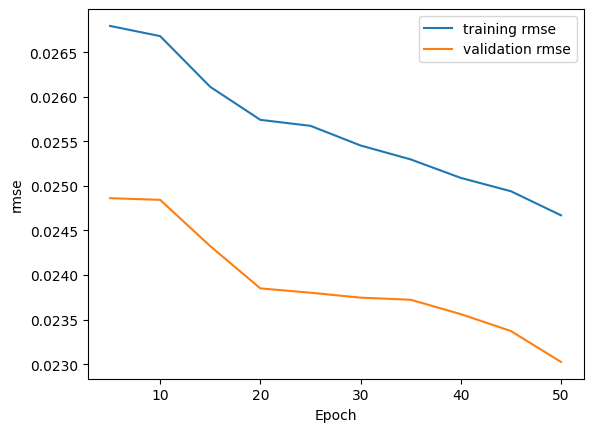

In [22]:
results=[epochs,train_rmse,val_rmse]
plt.plot(epochs,train_rmse,label='training rmse')
plt.plot(epochs,val_rmse,label='validation rmse')
plt.xlabel('Epoch') 
plt.ylabel('rmse') 
plt.legend()
plt.show()

The training rmse decreases consistently and quickly across epochs, agreeing that the model continues to fit the training data better with more epochs but risks overfitting. Meanwhile, the validation rmse starts high, decreases quickly, and stabilises after 30 epochs, indicating that larger epoch values only overfits the training data and has little effect on the validation set. 

Interestingly, the validation rmse is still slightly lower than the training even though both are performing more accurately than when the dataset was larger. This tells us that the lstm  performs better on smaller sets, and is better able to pick up on the patterns. It demonstrates that temporal continuity is not strictly necessary for the model to learn effectively.

### Decision
After much reasearch, testing and analysing we have decided 25 would be a good choice for the multivariate LSTM

## GPU vs CPU Performance

Using Apple's Metal API with Keras (TensorFlow)

In [23]:
!pip install tensorflow-macos
!pip install tensorflow-metal

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


This checks for the number of GPUs available on the system using TensorFlow's API. On Apple devices, tensor uses Apple's metal backend, which optimises machine learning by providing GPU hardware.

## Preprocess Data for GPU Usage 
The GPU version of tensorflow works with 32 bit floats which is important because some records might now return NAN if we use the dataset as it is now. The GPU is optimised for float32 precision, while CPU can handle float64. 

In [25]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('float64'))

In [26]:

def preprocess_sequences(X, y):
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    #Handle NAN and infinite values
    X = np.nan_to_num(X, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    y = np.nan_to_num(y, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

    #Cap extreme values 
    X = np.clip(X, -10, 10)  
    y = np.clip(y, -10, 10)

    return X, y


X_train_gpu, y_train_gpu,   =  preprocess_sequences(X_train, y_train)
X_test_gpu,y_test_gpu = preprocess_sequences(X_test, y_test)

In [27]:
X_train_gpu.dtype,y_train_gpu.dtype ,X_train.dtype, y_train.dtype

(dtype('float32'), dtype('float32'), dtype('float64'), dtype('float64'))

## CPU vs GPU Performance on Batch Size

In [28]:
import time

Note: We care more about computation time than rmse score because we want to theoretical analyse how our models will peroform if the dataset was scaled significantly. However, we also take into account the prevention of a significant increase in rmse score. 

In [29]:
batch_sizes = [16, 32, 64, 128, 256]  # Different batch sizes to test
results = {"batch_size": [], "cpu_rmse":[], "cpu_time": [],"gpu_rmse":[], "gpu_time": []}

Smaller batch sizes require more updates per epoch, leading to better convergence but increased computational perforamnce. Larger batch sizes processes more sequences and thus faster training times, but may result in lower accuracy and overfitting. A common rule of thumb is to try powers of 2.

Note: 
- GPUs theoreticcally should perform better with larger batch sizes because of their parallel processing capabilities, which efficiently handles more samples simultaneously.
- CPUs perform well with smaller batches because they can store smaller amounts of information in cache which has high bandwidth access.

## Batch Size vs Training Time

Note: we use epoch=10 otherwise testing will take quite some time.

In [30]:
split= int(0.9*len(X_train))

**WARNING** this takes approx 18 minutes to run.

In [31]:
for batch_size in batch_sizes:
   
    with tf.device('/CPU:0'): #Train with CPU
        # Reset weights to initial weights before starting new training attempts
        STCK_LSTM.set_weights(initial_weights)
        start_time = time.time()
        STCK_LSTM.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=batch_size, shuffle=False)
        cpu_time = time.time() - start_time
        CPU_scores = STCK_LSTM.evaluate(X_train[split:], y_train[split:])

  
    with tf.device('/GPU:0'): #Train with GPU
        STCK_LSTM.set_weights(initial_weights)
        start_time = time.time()
        STCK_LSTM.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=batch_size, shuffle=False)        
        gpu_time = time.time() - start_time
        GPU_scores = STCK_LSTM.evaluate(X_train[split:], y_train[split:])


    # Record results
    results["batch_size"].append(batch_size)
    results["cpu_rmse"].append(CPU_scores[1])
    results["cpu_time"].append(cpu_time)
    results["gpu_rmse"].append(GPU_scores[1])
    results["gpu_time"].append(gpu_time)

Epoch 1/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0040 - root_mean_squared_error: 0.0617 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 2/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 9.4454e-04 - val_root_mean_squared_error: 0.0307
Epoch 3/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 4/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 5/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 6/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 9.7832e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 7/10
2217/2217 ━━━━━

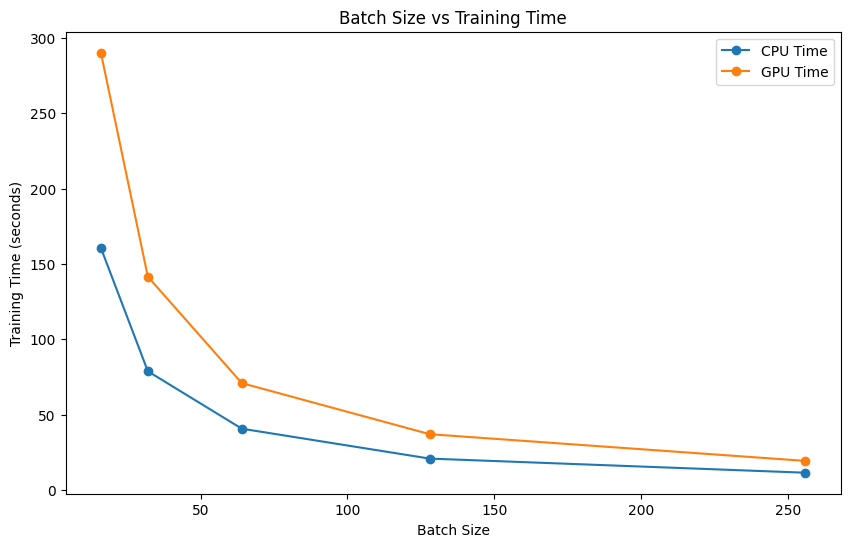

In [32]:

plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["cpu_time"], label="CPU Time", marker='o')
plt.plot(results["batch_size"], results["gpu_time"], label="GPU Time", marker='o')
plt.title("Batch Size vs Training Time")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()



As the batch size increases, the training time decreases significantly for both CPU and GPU. The CPU shows a steeper decline, demonstrating it is more efficient here in handling larger batch sizes.

This suggests the LSTM doesn't benefit from gpu's parallel capability. Likely because LSTMs handle sequential data where weights are updated in turn, meaning the GPU can't directly support parallelism and we will have to look into specific strategies to train in parallel.

We can still determine which processor is best to perform the sequential LSTM, taking into account it's prediction accuracy also. 

## Batch Size vs RMSE

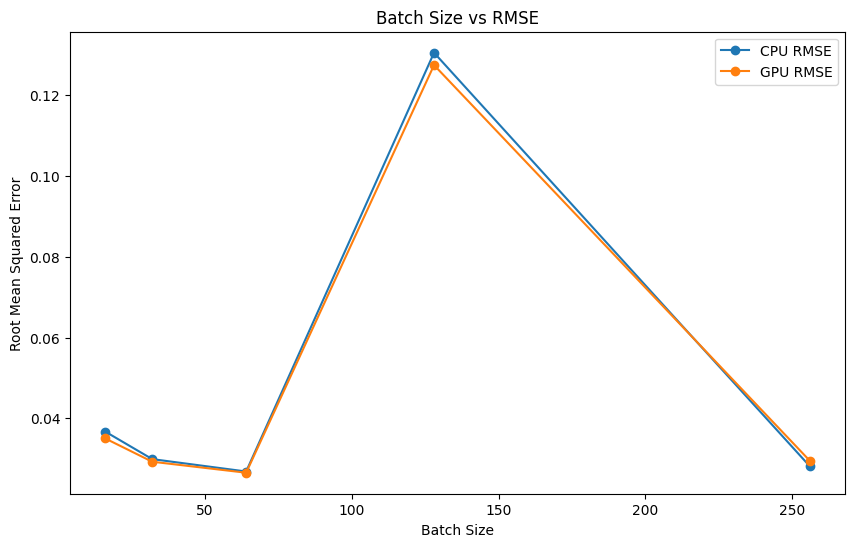

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["cpu_rmse"], label="CPU RMSE", marker='o')
plt.plot(results["batch_size"], results["gpu_rmse"], label="GPU RMSE", marker='o')
plt.title("Batch Size vs RMSE")
plt.xlabel("Batch Size")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.show()

This looks at how rmse changes for different batch sizes on CPU and GPU. Smaller batch sizes perform better with lower rmse for both CPU and GPU, likely because  they provide more frequent updates, leading to better convergence. However, as the batch size increases, rmse spikes significantly for both at 128, suggesting that the model struggles with generalisation, especially using GPU. The CPU however, maintains more stable rmse values across all batch sizes.

### Analysis

- As discussed an epoch value of 25 is quite good to avoid overfitting, generalise well and result in good rmse. Despite, not directly comparing computation time, after much trial and error as desribed in the LSTM_failures notebook, we came to the conclusion that any larger is unnecary for model accuracy and only adds to computation time. We care more about computation time because we want to theoretical analyse how our models will peroform if the dataset was scaled significantly. 
- A batch size of 100 provides a good trade-off between computational efficiency and rmse value. 
- While GPUs excel at at parallelism (which wasn't used here), the CPU performs more consistently across batch sizes and offers better generalisation on the validation set. Thus, it is better to use the CPU for the final model as it achieves good rmse accuracy without extreme computation power, more comparable to the univariate LSTM. 



# Final Model

- Batch size: 100
- processor: CPU
- Epochs: 25

In [34]:
with tf.device('/CPU:0'):
    STCK_LSTM.set_weights(initial_weights)
    STCK_LSTM.fit(X_train, y_train, epochs=25, validation_split=0.1, batch_size=100,shuffle=False)

Epoch 1/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0043 - root_mean_squared_error: 0.0650 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 2/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0614
Epoch 3/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 4/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430
Epoch 5/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 6/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 7/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step 

### Predict on Left-Out Test Data

In [35]:
test_predictions = STCK_LSTM.predict(X_test)

X_test_rescaled=X_test[:, -1, :].copy()

# Invert scaling for the forecast
inv_test_predictions = concatenate((test_predictions, X_test_rescaled[:, 1:]), axis=1)
inv_test_predictions = scaler.inverse_transform(inv_test_predictions)
inv_test_predictions = inv_test_predictions[:, 0]  # Extract the pollution column

y_test = y_test.reshape((len(y_test),1))
inv_actual_predictions = concatenate((y_test, X_test_rescaled[:, 1:]), axis=1)
inv_actual_predictions = scaler.inverse_transform(inv_actual_predictions)
inv_actual_predictions = inv_actual_predictions[:,0]


test_results = pd.DataFrame(data={
        'Model Predictions': inv_test_predictions,
        'Actual':inv_actual_predictions})
  

# calculate rmse
rmse = sqrt(mean_squared_error(inv_actual_predictions, inv_test_predictions))
print('Test RMSE: %.3f' % rmse)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test RMSE: 27.308


### Plot the Actual and Predicted Values

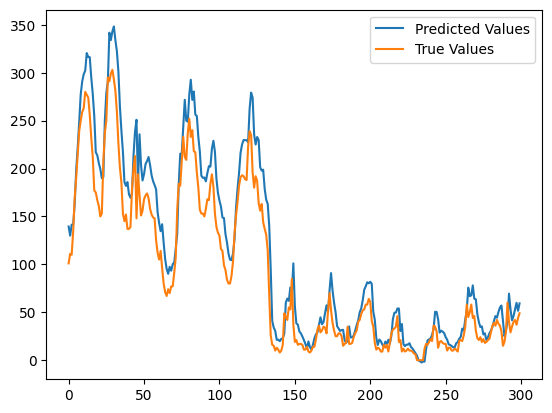

In [36]:
plt.plot(test_results['Model Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

The model performs pretty well, with an rmse of 43.5. The LSTM was able to effectively capture the patterns in the data, as evidence by the predictions mostly aligning with the peaks and variability of the true values. However it does seem like the model tends to overestimate the true values. 

## Reducing Complexity 

## 1) Autoencoder

We look at an autoencoder to detect any anomalies in the dataset.

In [37]:
X_train.shape

(39410, 10, 8)

The model needs time to learn the important patterns so we increase epoch value. More epochs allow the autoencoder to refine its latent representation by giving the model additional time to learn the most meaningful and compact features of the data. 

In [38]:
input_layer = Input(shape=(n_steps, n_features))

#Encoder
encoder = LSTM(50, return_sequences=False)(input_layer)

#Decoder 
decoder = RepeatVector(n_steps)(encoder)
decoder = LSTM(50, return_sequences=True)(decoder)
output_layer = TimeDistributed(Dense(n_features, activation='linear'))(decoder)

#Autoencoder 
encoder_decoder = Model(inputs=input_layer, outputs=output_layer)
encoder_decoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])

encoder_decoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 8)          │           408 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,408 (126.59 KB)

 Trainable params: 32,408 (126.59 KB)

 Non-trainable params: 0 (0.00 B)

**WARNING** this takes approx 9 minutes to run.

In [39]:
with tf.device('/CPU:0'):
    autoencode_history = encoder_decoder.fit(X_train, X_train, epochs= 75, validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0262 - root_mean_squared_error: 0.1562 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 2/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 3/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 4/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 5/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 6/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0831
Epoch 7/75
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

In [40]:
X_train.shape, y_train.shape

((39410, 10, 8), (39410, 1))

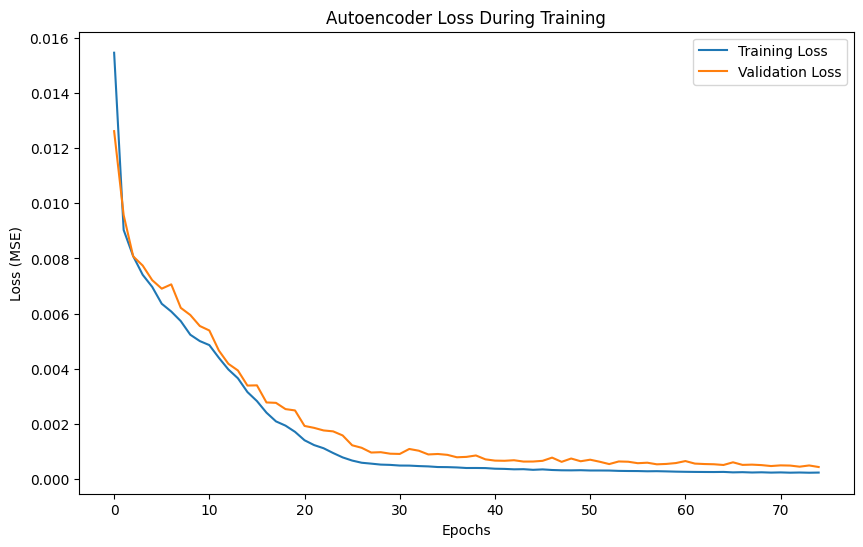

In [41]:
#Plot mle loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(autoencode_history.history['loss'], label='Training Loss')
plt.plot(autoencode_history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

It seems like the autoencoder is able to reproduce the training set well, with mle loss decaying steadily and stabilising arounf 40

## Extract Encoder

In [42]:
#Extract the encoder part
encoder = Model(inputs=input_layer, outputs=encoder)
encoder.summary()

encoded_X_train = encoder.predict(X_train)
encoded_X_test = encoder.predict(X_test)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        11,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,800 (46.09 KB)

 Trainable params: 11,800 (46.09 KB)

 Non-trainable params: 0 (0.00 B)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


encoded_X_train and encoded_X_test now represent a reduced dimensional representation of the original data

In [43]:

#Build a new model to predict y_train from the encoded
predictor_model = Sequential()
predictor_model.add(Input(shape=(encoded_X_train.shape[1],))) 
predictor_model.add(Dense(50))  
predictor_model.add(Dense(n_outputs, activation='linear'))  
predictor_model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

#Train the model
predictor_model.fit(encoded_X_train, y_train, epochs=20, validation_split=0.1, batch_size=100, shuffle=False )
y_pred = predictor_model.predict(encoded_X_test)

mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse_test:.4f}')


Epoch 1/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0088 - root_mean_squared_error: 0.0898 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 2/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 4/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 5/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 6/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 7/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

In [44]:
encoded_X_train.shape

(39410, 50)

In [45]:
actual = y_test.flatten()
pred = y_pred.flatten()

In [46]:
results = pd.DataFrame(data={
    "test_actual": actual,
    "test_pred" : pred
})

In [47]:
results

,test_actual,test_pred
0,0.101610,0.135160
1,0.111670,0.129362
2,0.110664,0.120406
3,0.134809,0.106763
4,0.170020,0.122850
...,...,...
4365,0.008048,0.038473
4366,0.010060,0.037071
4367,0.010060,0.037071
4368,0.008048,0.033273


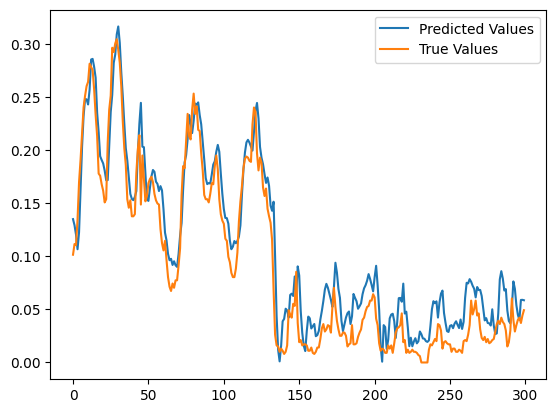

In [48]:
plt.plot(results['test_pred'][:300], label='Predicted Values')
plt.plot(results['test_actual'][:300], label='True Values')
plt.legend()
plt.show()

You should be aware that the better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.

Let's take a look at the layers of the encoder_decoder model:


Assess how well the reconstructed dataset matches the original.

Train a new model MLP or LSTM using bottleneck_features
- try clustering 

Plot the original sequence and reconstructed sequence to see how well the model is performing visually

The reconstructed sequence follows the general trend of the original sequence but does not perfectly match the exact values. For example, the reconstructed values seem to lag slightly behind the original at certain points and do not capture sharp peaks.

## Modify the decoder to predict future time steps instead of reconstructing the input.

## 2) Lag-1 Features 

In [49]:
window_size = 2
N= len(train_data)
X_train_lagged, y_train_lagged = generate_sequence(train_data,N, window_size)
print(X_train_lagged.shape, y_train_lagged.shape)

M=len(test_data)
X_test_lagged, y_test_lagged = generate_sequence(test_data,M,window_size)
print(X_test_lagged.shape,y_test_lagged.shape)

(39418, 2, 8) (39418, 1)
(4378, 2, 8) (4378, 1)


In [50]:
n_steps = X_train_lagged.shape[1]
n_features = X_train_lagged.shape[2]
n_outputs = y_train_lagged.shape[1]

In [51]:
n_steps

2

In [52]:
tf.random.set_seed(7)
LAG_LSTM = Sequential()
LAG_LSTM.add(Input(shape =(n_steps, n_features)))
LAG_LSTM.add(LSTM(32,return_sequences=True))
LAG_LSTM.add(Dropout(0.1)) #Prevent overfitting
LAG_LSTM.add(LSTM(16, return_sequences=False))
LAG_LSTM.add(Dense(n_outputs, activation ='linear')) 

LAG_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])

initial_lag_weights = LAG_LSTM.get_weights()

LAG_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 2, 32)          │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
batch_sizes = [16, 32, 64, 128, 256]  # Different batch sizes to test
results = {"batch_size": [], "lag_rmse":[], "lag_time": [],"stck_rmse":[], "stck_time": []}

In [54]:
for batch_size in batch_sizes:
    # CPU
    with tf.device('/CPU:0'):
        STCK_LSTM.set_weights(initial_weights)
        start_time = time.time()
        STCK_LSTM.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=batch_size, shuffle=False)
        stck_time = time.time() - start_time
        stck_scores = STCK_LSTM.evaluate(X_test, y_test)

    # GPU
    with tf.device('/CPU:0'):
        LAG_LSTM.set_weights(initial_lag_weights)
        start_time = time.time()
        LAG_LSTM.fit(X_train_lagged, y_train_lagged, epochs=10, validation_split=0.1, batch_size=batch_size, shuffle=False)        
        lag_time = time.time() - start_time
        lag_scores = LAG_LSTM.evaluate(X_test, y_test)


    # Record results
    results["batch_size"].append(batch_size)
    results["lag_rmse"].append(lag_scores[1])  # Root Mean Squared Error for LAG_LSTM
    results["lag_time"].append(lag_time)
    results["stck_rmse"].append(stck_scores[1])  # Root Mean Squared Error for STCK_LSTM
    results["stck_time"].append(stck_time)

Epoch 1/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0041 - root_mean_squared_error: 0.0624 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 2/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 3/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 4/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 5/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 6/10
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 9.8491e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 7/10
2217/2217 ━━━━━━━━━

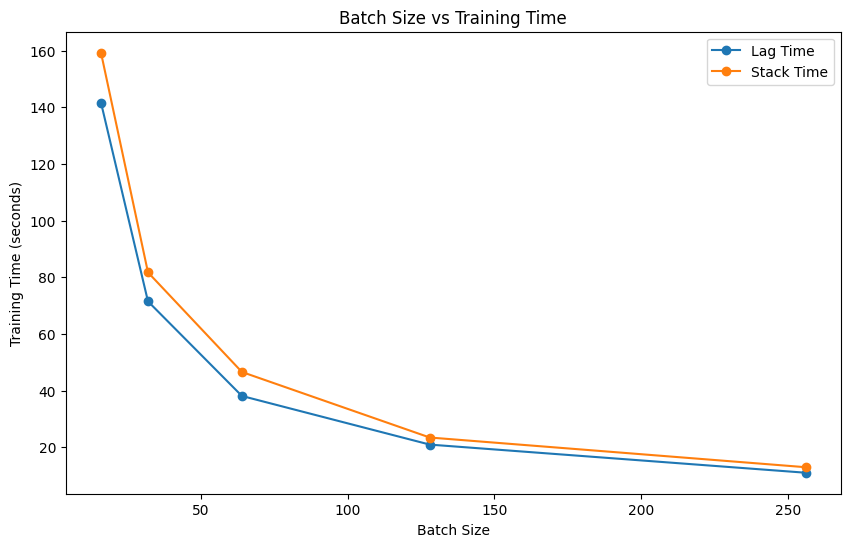

In [55]:

plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["lag_time"], label="Lag Time", marker='o')
plt.plot(results["batch_size"], results["stck_time"], label="Stack Time", marker='o')
plt.title("Batch Size vs Training Time")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()

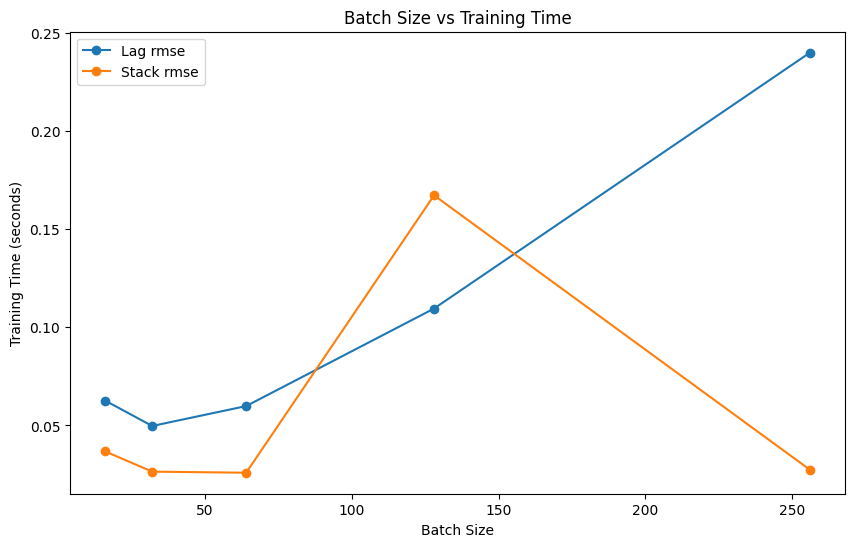

In [56]:

plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["lag_rmse"], label="Lag rmse", marker='o')
plt.plot(results["batch_size"], results["stck_rmse"], label="Stack rmse", marker='o')
plt.title("Batch Size vs Training Time")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()

# PYSPARKING for Large Datasets

The generate_sequence function we use to make sequences of the dataset can become computationally expensive as the dataset grows because of the sequential nature of the for loop. As a result, we investigate if spark is able to distribute the workload and produce sequences in parallel across different parts of the dataset. 

In [57]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

In [59]:
df = pd.read_csv

In [60]:

# Set up the distribution strategy
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [61]:
num_gpus = 1 #Number of available GPUs


Epoch 1/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0682 - loss: 0.0047

2024-11-27 01:00:10.883934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:10.883969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - RootMeanSquaredError: 0.0681 - loss: 0.0047 - val_RootMeanSquaredError: 0.0647 - val_loss: 0.0042
Epoch 2/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0421 - loss: 0.0019    

2024-11-27 01:00:11.556338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:11.556362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0481 - loss: 0.0023

2024-11-27 01:00:17.759851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:17.760002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0481 - loss: 0.0023 - val_RootMeanSquaredError: 0.0489 - val_loss: 0.0024
Epoch 3/30
 10/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0343 - loss: 0.0012    

2024-11-27 01:00:18.103596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:18.103627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


553/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0404 - loss: 0.0016

2024-11-27 01:00:24.801959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:24.802444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - RootMeanSquaredError: 0.0404 - loss: 0.0016 - val_RootMeanSquaredError: 0.0391 - val_loss: 0.0015
Epoch 4/30
  1/555 ━━━━━━━━━━━━━━━━━━━━ 1:27 158ms/step - RootMeanSquaredError: 0.0223 - loss: 4.9680e-04

2024-11-27 01:00:25.242383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:25.242411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


552/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0358 - loss: 0.0013

2024-11-27 01:00:32.236471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:32.236550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - RootMeanSquaredError: 0.0358 - loss: 0.0013 - val_RootMeanSquaredError: 0.0342 - val_loss: 0.0012
Epoch 5/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0276 - loss: 7.7494e-04

2024-11-27 01:00:32.567495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:32.567518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0334 - loss: 0.0011

2024-11-27 01:00:38.513834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:38.513902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0334 - loss: 0.0011 - val_RootMeanSquaredError: 0.0299 - val_loss: 8.9189e-04
Epoch 6/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - RootMeanSquaredError: 0.0267 - loss: 7.2206e-04

2024-11-27 01:00:38.864551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:38.864588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0329 - loss: 0.0011

2024-11-27 01:00:45.360658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:45.360697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0329 - loss: 0.0011 - val_RootMeanSquaredError: 0.0318 - val_loss: 0.0010
Epoch 7/30
  5/555 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - RootMeanSquaredError: 0.0219 - loss: 4.8297e-04 

2024-11-27 01:00:45.812271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:45.812325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - RootMeanSquaredError: 0.0325 - loss: 0.0011

2024-11-27 01:00:53.295848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:53.295883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - RootMeanSquaredError: 0.0325 - loss: 0.0011 - val_RootMeanSquaredError: 0.0297 - val_loss: 8.8129e-04
Epoch 8/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0246 - loss: 6.1749e-04

2024-11-27 01:00:53.734456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:00:53.734481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0316 - loss: 0.0010

2024-11-27 01:01:00.158084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:00.158144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0316 - loss: 0.0010 - val_RootMeanSquaredError: 0.0286 - val_loss: 8.1748e-04
Epoch 9/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0232 - loss: 5.4686e-04

2024-11-27 01:01:00.514748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:00.514770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


552/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0316 - loss: 0.0010

2024-11-27 01:01:06.955510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:06.955562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0316 - loss: 0.0010 - val_RootMeanSquaredError: 0.0276 - val_loss: 7.5913e-04
Epoch 10/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0227 - loss: 5.3244e-04

2024-11-27 01:01:07.320090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:07.320111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


552/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0314 - loss: 0.0010

2024-11-27 01:01:14.217355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:14.217411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - RootMeanSquaredError: 0.0314 - loss: 0.0010 - val_RootMeanSquaredError: 0.0276 - val_loss: 7.6272e-04
Epoch 11/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0224 - loss: 5.1860e-04

2024-11-27 01:01:14.578606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:14.578628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0310 - loss: 9.7377e-04

2024-11-27 01:01:20.706629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:20.706666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0310 - loss: 9.7355e-04 - val_RootMeanSquaredError: 0.0281 - val_loss: 7.8875e-04
Epoch 12/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - RootMeanSquaredError: 0.0228 - loss: 5.3561e-04

2024-11-27 01:01:21.050608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:21.050629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


551/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0316 - loss: 0.0010

2024-11-27 01:01:27.153750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:27.153798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0316 - loss: 0.0010 - val_RootMeanSquaredError: 0.0277 - val_loss: 7.6555e-04
Epoch 13/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0223 - loss: 5.1302e-04

2024-11-27 01:01:27.495675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:27.495697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


551/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0311 - loss: 9.8456e-04

2024-11-27 01:01:33.448642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:33.448686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0311 - loss: 9.8324e-04 - val_RootMeanSquaredError: 0.0272 - val_loss: 7.4140e-04
Epoch 14/30
  3/555 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - RootMeanSquaredError: 0.0163 - loss: 2.7608e-04

2024-11-27 01:01:33.786440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:33.786462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


553/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0306 - loss: 9.5346e-04

2024-11-27 01:01:39.739639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:39.739685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0306 - loss: 9.5275e-04 - val_RootMeanSquaredError: 0.0279 - val_loss: 7.7798e-04
Epoch 15/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - RootMeanSquaredError: 0.0215 - loss: 4.8216e-04

2024-11-27 01:01:40.080135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:40.080162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0307 - loss: 9.5742e-04

2024-11-27 01:01:46.221927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:46.221966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0307 - loss: 9.5718e-04 - val_RootMeanSquaredError: 0.0273 - val_loss: 7.4682e-04
Epoch 16/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0218 - loss: 4.9979e-04

2024-11-27 01:01:46.592162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:46.592184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0306 - loss: 9.5281e-04

2024-11-27 01:01:52.711084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:52.711147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0306 - loss: 9.5234e-04 - val_RootMeanSquaredError: 0.0270 - val_loss: 7.3066e-04
Epoch 17/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0215 - loss: 4.8425e-04

2024-11-27 01:01:53.052698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:53.052727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


552/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0304 - loss: 9.3630e-04

2024-11-27 01:01:59.331016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:59.331069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0303 - loss: 9.3535e-04 - val_RootMeanSquaredError: 0.0276 - val_loss: 7.6396e-04
Epoch 18/30
  1/555 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - RootMeanSquaredError: 0.0134 - loss: 1.8010e-04

2024-11-27 01:01:59.676105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:01:59.676140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0301 - loss: 9.1820e-04

2024-11-27 01:02:05.750150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:05.750187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0301 - loss: 9.1800e-04 - val_RootMeanSquaredError: 0.0276 - val_loss: 7.6239e-04
Epoch 19/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0214 - loss: 4.7748e-04

2024-11-27 01:02:06.100971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:06.100999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0297 - loss: 8.9195e-04

2024-11-27 01:02:12.026337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:12.026377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0297 - loss: 8.9177e-04 - val_RootMeanSquaredError: 0.0276 - val_loss: 7.6214e-04
Epoch 20/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - RootMeanSquaredError: 0.0220 - loss: 5.0355e-04

2024-11-27 01:02:12.386492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:12.386511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


552/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0295 - loss: 8.8137e-04

2024-11-27 01:02:18.288641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:18.288675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0295 - loss: 8.8066e-04 - val_RootMeanSquaredError: 0.0274 - val_loss: 7.5347e-04
Epoch 21/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - RootMeanSquaredError: 0.0220 - loss: 5.0485e-04

2024-11-27 01:02:18.632184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:18.632207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0295 - loss: 8.7830e-04

2024-11-27 01:02:24.871588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:24.871620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0295 - loss: 8.7813e-04 - val_RootMeanSquaredError: 0.0273 - val_loss: 7.4480e-04
Epoch 22/30
  6/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0185 - loss: 3.5616e-04 

2024-11-27 01:02:25.305218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:25.305238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


551/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0289 - loss: 8.4608e-04

2024-11-27 01:02:31.509765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:31.509855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0289 - loss: 8.4536e-04 - val_RootMeanSquaredError: 0.0274 - val_loss: 7.4903e-04
Epoch 23/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0215 - loss: 4.8197e-04

2024-11-27 01:02:31.836689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:31.836719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0288 - loss: 8.3641e-04

2024-11-27 01:02:38.343434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:38.343487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0288 - loss: 8.3628e-04 - val_RootMeanSquaredError: 0.0283 - val_loss: 7.9821e-04
Epoch 24/30
  6/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0189 - loss: 3.7178e-04 

2024-11-27 01:02:38.709585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:38.709609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0287 - loss: 8.3288e-04

2024-11-27 01:02:45.230336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:45.230381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0287 - loss: 8.3274e-04 - val_RootMeanSquaredError: 0.0276 - val_loss: 7.5993e-04
Epoch 25/30
 10/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0217 - loss: 4.9438e-04

2024-11-27 01:02:45.611538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:45.611559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0284 - loss: 8.1273e-04

2024-11-27 01:02:51.586414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:51.586457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0284 - loss: 8.1250e-04 - val_RootMeanSquaredError: 0.0278 - val_loss: 7.7467e-04
Epoch 26/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 0.0214 - loss: 4.7823e-04

2024-11-27 01:02:51.940683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:51.940708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


553/555 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - RootMeanSquaredError: 0.0285 - loss: 8.1750e-04

2024-11-27 01:02:59.077209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:59.077284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - RootMeanSquaredError: 0.0285 - loss: 8.1714e-04 - val_RootMeanSquaredError: 0.0282 - val_loss: 7.9773e-04
Epoch 27/30
 11/555 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0217 - loss: 4.8934e-04

2024-11-27 01:02:59.426162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:02:59.426186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0283 - loss: 8.1061e-04

2024-11-27 01:03:05.873826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:05.873888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0283 - loss: 8.1039e-04 - val_RootMeanSquaredError: 0.0283 - val_loss: 8.0038e-04
Epoch 28/30
 10/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0213 - loss: 4.7380e-04

2024-11-27 01:03:06.219356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:06.219378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


554/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0282 - loss: 8.0271e-04

2024-11-27 01:03:12.461862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:12.461916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0282 - loss: 8.0248e-04 - val_RootMeanSquaredError: 0.0279 - val_loss: 7.8007e-04
Epoch 29/30
 10/555 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0214 - loss: 4.7443e-04

2024-11-27 01:03:12.795667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:12.795703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


553/555 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RootMeanSquaredError: 0.0280 - loss: 7.8828e-04

2024-11-27 01:03:19.309128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:19.309764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0280 - loss: 7.8798e-04 - val_RootMeanSquaredError: 0.0283 - val_loss: 8.0107e-04
Epoch 30/30
  1/555 ━━━━━━━━━━━━━━━━━━━━ 1:20 145ms/step - RootMeanSquaredError: 0.0113 - loss: 1.2830e-04

2024-11-27 01:03:19.703004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:19.703283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


553/555 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0280 - loss: 7.9035e-04

2024-11-27 01:03:26.042866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:26.042906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - RootMeanSquaredError: 0.0280 - loss: 7.9001e-04 - val_RootMeanSquaredError: 0.0281 - val_loss: 7.9021e-04


2024-11-27 01:03:26.386771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-27 01:03:26.386793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


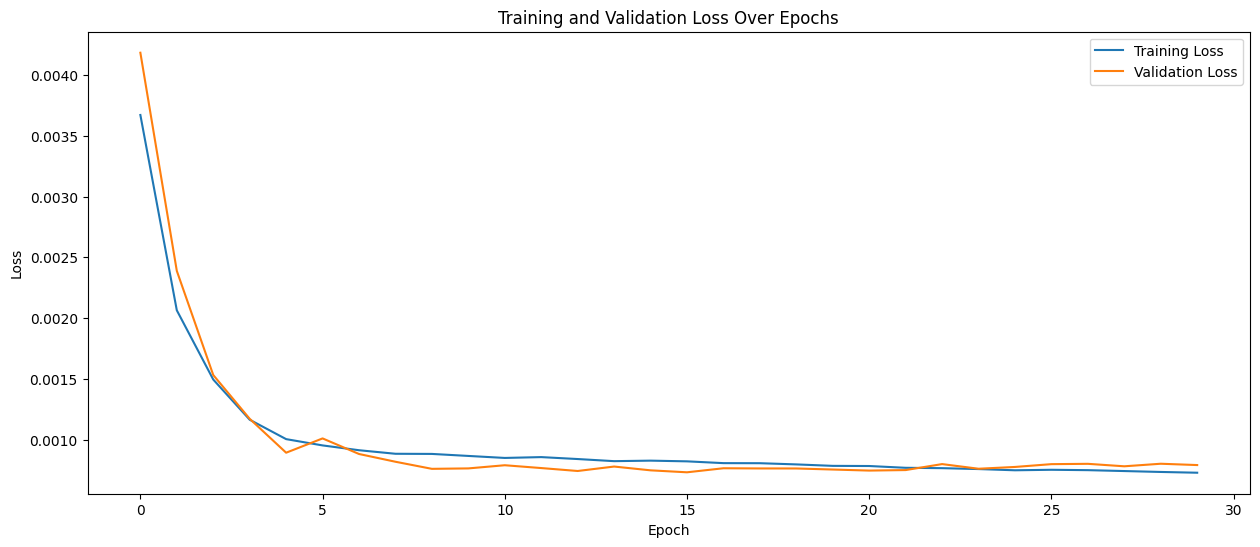

In [62]:
with strategy.scope():
    tf.random.set_seed(7)  
    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.1))  
    model.add(LSTM(16, return_sequences=False))
    model.add(Dense(n_outputs, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['RootMeanSquaredError'])


history = model.fit(X_train, y_train, epochs=30, validation_split=0.1,  batch_size=64, shuffle=False)

plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()
